In [1]:
#boilerplate
import numpy as np
import scipy.stats as stat
import scipy.fftpack as fft
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.linalg as la
# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
import scipy.optimize as opt
import imageio as io

# Phase 3

In this project, we want to use PDEs in an application to images to try to restore them. To do so, we need to break down what we're actually intending to do. Digital images (namely greyscale images) are just 2D arrays of values, telling us the value of the intensity at each pixel. If we have some portion of the image that has been damaged, we want to be able to know what the intensity of each missing pixel was intended to be. To do this, we can use the Laplace equation for inward propagation of intensities.

In this phase, we will implement the inpainting scheme and the tests that we put forth in phase 2. we plan to first take our clown image  and remove a portion of the image. We would perform diffusion on the entire image to smooth out the image slightly. We would then perform steps of inpainting alternating with steps of diffusion only on the empty region with known boundaries in order to fill in the hole and then smooth out any noise that appears. Then after the inpainted region has been filled we would perform the chisquared analysis between the observed inpainted image and the 'expected'(original) image. We will do this for different sizes of the missing region and to determine the behavior of the chi squared metric. We can also look qualitatively at the image to determine when significant changes begin to appear. We can also perform this test on the 'pixval' array as it has much easier behavior compared to the clown image and therefore should allow the laplace equation to fill in a larger region. 

## Bug fixes
We had to perform a few bug fixes on the functions we made for phase 2 in order to get things straight for phase 3. 

*non-square images* 
In phase 2, we never tested non-square images, which led to a few of our functions not being generalized to non-square images. For example, we tested and messed with window_boundaries function more and found that it only works with symmetric (square) pictures because the function as written cannot broadcast the matrix to another shape. We wrote a new function called window_bounds which is more general and can now handle asymmetric pictures. 

*diffusion mask* 
A further bug fix was for diffusion, where we added a mask so that when we pass positions in the matrix that we want to diffuse over, we can do those instead of diffusing over the entire image.

*chi-squared* 
Furthermore, we realized that the previous chi_squared method was wrong, as well. It did not handle places where the real image was zero, because it divided the difference between the real and smoothed images by the real image, leading to divide by zero errors. Instead, we created our own chisquared method, which appears in project2_phase2.py. The function takes the difference between the observed and expected matrices, squares that value, sums it in both dimensions, and then divides by the size of the expected matrix. Then, we use the stat.tstd function to find the standard deviation, and divide by the standard deviation squared, dividing again by the size of the expected matrix to account for normalization.

## Importing methods from phase 2
Instead of retyping or copying all those methods from phase 2, we decided to copy them to a .py file and add it to the git, so that we could import this as a module with a variety of functions that we could call, as shown below. This makes this document far less cluttered and more short. However, if you want to look at the changes we made to phase 2 methods, you'll have to refer to that document. 

In [2]:
import project2_phase2 as p2p2

# Working with Laplace Equation
Here we attempt to implement the laplace equation into code with the form, 
$$\rho(x,y) = \frac{\partial^{2}{I}}{\partial{y}^{2}} + \frac{\partial^{2}{I}}{\partial{x}^2}$$
where $I(x,y)$ is the picture function. No source terms gives a solution function $u(x,y)$ as 
$$0 = \frac{\partial^{2}{u}}{\partial{y}^{2}} + \frac{\partial^{2}{u}}{\partial{x}^{2}}$$
which means we need to discretize to do this numerically so we will do this on a grid with step size $\Delta x = \Delta y == \Delta$
such that for all points $\in x,y$ we can define $x_{j} = x_{0} + j \Delta$ and $y_{l} = y_{0} + l \Delta$ for $j = 0,...,J$ and $l = 0,...,L$

Using center differencing with our grid we get the equation,
$$ 0 = \frac{u_{j+1,l} + u_{j,l+1} + u_{j-1,l} + u_{j,l-1} - 4u_{j,l}}{\Delta^2} $$
we want to solve this as a system of linear equations and solve in the form $\underline{A}\vec{u} = \vec{b}$. To do this we have to do a little finesse. The finess is for a couple reasons. For one, we need to make the BCs part of $\vec{b}$, and secondly we need to change $u_{j,l}$ to a 1-D array.

We use Direchlet BCs, which means we know $u_{j,l}$ when $j=0,J$ and $l=0,L$. Consequently, we can move those terms to the LHS of the equation and make that an element of $\vec{b}$, but first let's worry about making $u_{j,l}$ a 1-D array.

we can map $u_{j,l}$ to a 1-D array $u_{i}$ by defining $i = j(L+1) + l$ for $j = 0,...,J$ and $l = 0,...,L$ which means for the interior points ($j=1,...,J-1$ and $l=1,...,L-1$) our equationn becomes
$$ 0 = \frac{u_{i+(L+1)} + u_{i+1} + u_{i-(L+1)} + u_{i-1} - 4u_{i}}{\Delta^2} $$ 
where the new $u$'s are in the same order at the previous eqn. 

As for the BCs, they have been mapped in this way,
$$
\begin{align}
j&=0  &  i &= 0,1,...,L \\
j&=J  &  i &= J(L+1),J(L+1)+1,...,J(L+1)+L \\
l&=0  &  i &= 0,L+1,2(L+1),...,J(L+1) \\
l&=L  &  i &= L,L+1+L,2(L+1)+L,...,J(L+1)+L
\end{align}
$$
and so at those $u_{i}$ values we can moves those terms over to $\vec{b}$

which gives us $\underline{A}\vec{u} = \vec{b}$. 

## implementing the laplace equation

here is the function that makes $\underline{A}$ and $\vec{b}$, the rest of the documentation is in the function below

In [5]:
def make_ab(n,BC):
    '''
    here were gonna make A and vector b to solve the linear sys of eqn of the form Au=b
    A should be a banded tri diag matrix and b is gonna be = 0 except for the boundary points
    assumes square grid, and no source terms, see markdown above for how it should be that is easier on the eyes
    also doesnt return a sparse ass matrix cuz thats silly
    as of (10/27) this is going to be used for implentation in 'la.solveh_banded' WITH 'lower'=TRUE
    as of (10/27) assumes that a nxn pixel picture that we want to inpaint translates to an n*(n+1)+n by n*(n+1)+n matrix because
    of going from an nxn matrix for u_j,l into a 1-d array u_i
    it is being implemented in a similar fashion to Numerical Recipes 3rd, chap. 20
    inputs:
    n - integer, the number of pixels in the region of the picture we are trying to solve (either the zooomed or chunk removed version)
    note n = J = L
    BC - 4xJ(or L) array, array with values at the boundary, see 'window_boundaries' function for full doc but
        0th row - l=0
        1st row - l=L
        2nd row - j=0
        3rd row - j=J
    outputs: as a tuple (A,b)
    A - (n+1)xi array, the matrix A, where the values go from the diag to the last top-most non-zero diagonal,
    basically the upper triangular (kinda), of A
    b - len(i) 1-d array, long array, RHS of eqn, mostly 0's but with boundary terms
    '''
    i = np.linspace(0,(n*(n+1)+n),(n*(n+1)+n)+1,dtype=int)
    b = np.zeros(i[-1])
    # lets do b first 
    b[0:n] = BC[2,:]
    b[n*(n+1)::] = BC[3,:]
    b[:n*(n+1):(n+1)] = BC[0,:]
    b[n::(n+1)] = BC[1,:]
#     # now time for A
    lowa = np.ones(((n),i[-1]))
    lowa[0,::n] = lowa[1,(n-1)::n] = lowa[1,-2::] = 0 #second diag
    lowa[1:-1:,:] = 0 #now i gotta make all the other guys 0 now
    lowa[-1,::n] = lowa[-1,(n-1)::n] = lowa[-1,-(n+2)::] = 0 #final non zero diag
    test = np.ones(((2*n+1),i[-1]))
    test[:n:,:] = lowa[::-1]
    test[n,::n] = test[n+1,-1] = -0.
    test[n,:] *= -4.
    test[n+1::,:] = lowa
    del lowa
    return (test[:,1:-1:],b)

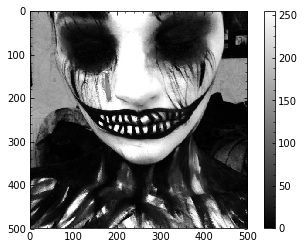

In [4]:
clown = io.imread('clown.jpg')
clown_grey = p2p2.make_greyscale(clown)
plt.imshow(clown_grey, cmap = "gray")
plt.colorbar()

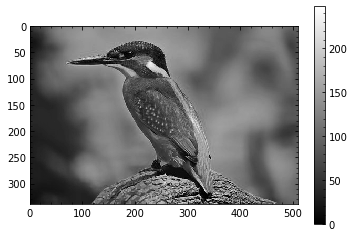

In [5]:
#non symmetric example to show we can do it
bird = io.imread('bird.jpg')
bird_grey = p2p2.make_greyscale(bird)
plt.imshow(bird_grey, cmap = 'gray')
plt.colorbar()

# Plan of attack
We plan to first take our clown image  and remove a portion of the image. We then plan to perform diffusion on the entire image to smooth it out slightly. We then want to perform steps of inpainting alternating with steps of diffusion only on the empty region with known boundaries in order to fill in the hole and then smooth out any noise that appears. Then after the inpainted region has been filled, we want to perform the chisquared analysis between the observed inpainted image and the 'expected'(original) image. We will do this for different sizes of the missing region and to determine the behavior of the chi squared metric. We can also look qualitatively at the image to determine when significant changes begin to appear. We can also perform this test on the 'pixval' array as it has much easier behavior compared to the clown image and therefore should allow the laplace equation to fill in a larger region. 

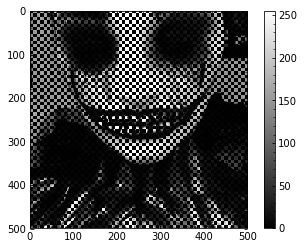

In [6]:
half_clown = p2p2.take_half(clown_grey)
plt.imshow(half_clown, cmap = "gray")
plt.colorbar()

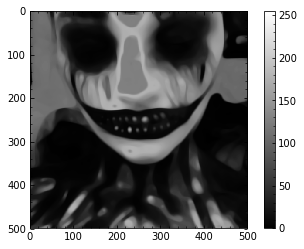

In [7]:
diffused_clown = p2p2.diffusion(half_clown,100)
plt.imshow(diffused_clown, cmap = "gray")
plt.colorbar()

(120, 120)


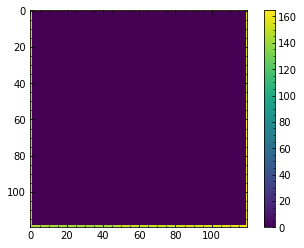

In [8]:
bounds = p2p2.window_bounds(clown_grey,window_size = (10,10))

(80, 120)


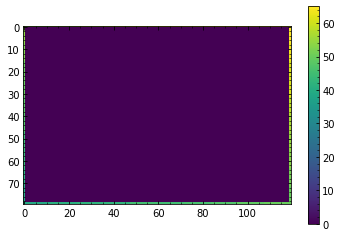

In [9]:
bird_bounds = p2p2.window_bounds(bird_grey,window_size = (10,10))

481.405448789264
7236.617677174122


2.6609417286626723e-07

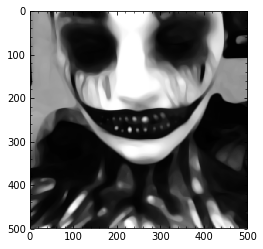

In [10]:
diffused = p2p2.diffusion(clown_grey,100)
plt.imshow(diffused,cmap ="gray")
chisq = p2p2.chisquared(diffused,clown_grey)
chisq

Unfortunately during our implementation testing of our FD method for solving the laplace eqn, we encountered the issue that the matrix solver library in 'scipy.linalg' could not handle our matrix, and while it would have been great to find a way to make this matrix easier to handle computationally, it seemed out of reach within the deadline. So we have now decided to move onto another, hopefully more succesful method.

# Fourier analysis time

since the eigenfunctions to the laplace equation are harmonic, we wanted to try a spectral method as that would do away with the issues we encountered in our fourier (get it lol, like foray lmao) into FD methods.

So going off of the framework from numerical methods we are going to implement the FT as a sum of homogenous and non-homongenous terms,
$$ u = u' + I^{B}$$
where $u'=0$ on the boundaries and $I^{B}$ is equal to the pixel values of the picture at the boundary that we are attempting to inpaint. And so now our laplace equation is given as,
$$\nabla^{2}u' = -\nabla^{2}I^{B}$$
as we have been working without any source terms since the begining, aka $\rho=0.$

Now on our discritized mesh, the one we have been using the whole time, $I^{B}=0$ in the interior points, so the only point in which $I^{B}$ would be evaluated at is at the point $(J-1,L-1)$

ill follow the rest of the derivation for our specific case whn i get done wiht my event, love you bois and im so fuckin sorry i have this event.


In [7]:
def sol(rho):
    """
    Transforms square force matrix rho in matrix values u for laplace's equation in frequency space
    
    Params
    ------
    rho : ndarray
      2-Dimensional matrix of the force terms of laplace's equation
    
    Returns
    -------
    sol : ndarray
      The solution u in the frequency domain in a matrix of size rho
    """
    delta=1/rho.shape[0]
    J,L=rho.shape
    a,b=np.mgrid[0:J,0:L]
    denom=2*(np.cos(2*np.pi*a/J)+np.cos(2*np.pi*b/L)-2)
    u=rho
    u[1:,1:]=rho[1:,1:]*delta**2/denom[1:,1:]
    return u

We chose our force term to be the elements of the image we did not paint over but since we paint over the region we just have rho be the fourier transform of our image with missing regions

In [25]:
def inpaint(init,start,window_size,time=0):
    """
    Takes a an initial image init and performs inpainting in the region indicated by start and window size
    
    Params
    ------
    init : ndarray
      2-Dimensional matrix of the image to be inpainted
    start : ndarray
      (2,) array with the (x,y) coordinates of the top left of the region to be inpainted
    window_size : ndarray
      (2,) array with the (x,y) dimensions of the hole to be inpainted
    time : int
        time you would like for diffusion to be run, if none set to =0
    
    Returns
    -------
    final : ndarray
      The image with the inpainted region covered
    """
    final=np.copy(init)
    step=np.copy(init)
    xo,yo=start
    xf,yf=start+window_size
    length=init.shape[0]
    for i in range((xf-xo)//2+1):
        p2p2.diffusion(step,T=time) #we can try this to see if it works just increase T for more diffusion
        F=fft.dstn(step,type=1)
        plz=sol(F)
        step=fft.idstn(plz,type=1)/((2*np.sqrt(F.size))**2) 
        J,L=final.shape
        j,l=step.shape
        dj=int ((J-j)/2)
        dl=int ((L-l)/2)
        final[i+xo:xf-i,i+yo:yf-i]=step[i+xo:xf-i,i+yo:yf-i]
    plt.imshow(final,cmap ="gray")
    return final

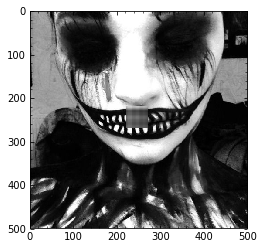

In [26]:
start=np.array([220,220])
window_size=np.array([50,50])
init=p2p2.make_hole(clown_grey,window_size = window_size,start=start)
f = inpaint(init,start,window_size)

also just based of off what num. recipes is saying we should do above plus some sort non-homogenous term, and to account for the fact that we have actual values we need at the boundary(idk what this is about exactly but you can try it)

### To find a goodness of fit of the inpainting use the chi squared. This is good for checking how big the hole can get before the region gets ugly or how many steps of diffusion is optimal for image. You can try different force terms(like the homogenous solution) or different images and see how it fairs there. You could also try to do a color image if you're feeling really ambitious

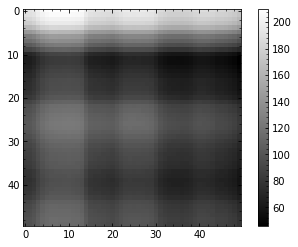

In [15]:
#zoomed in inpainted region, T=0
xo,yo=start
xf,yf=start+window_size
plt.imshow(f[xo:xf,yo:yf],cmap ="gray")
plt.colorbar()

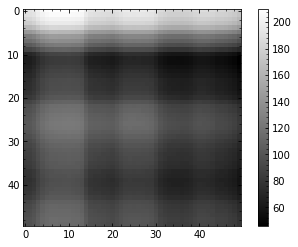

In [17]:
#zoomed in inpainted region, T=10
xo,yo=start
xf,yf=start+window_size
f2 = inpaint(init,start,window_size,time=10)
plt.imshow(f2[xo:xf,yo:yf],cmap ="gray")
plt.colorbar()

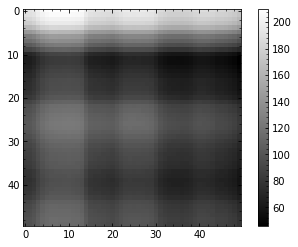

In [21]:
#zoomed in inpainted region, T=50, time to run ~ 1-2 min
xo,yo=start
xf,yf=start+window_size
f3 = inpaint(init,start,window_size,time=50)
plt.imshow(f3[xo:xf,yo:yf],cmap ="gray")
plt.colorbar()

In [22]:
assert(np.allclose(f,f2))

In [23]:
assert(np.allclose(f,f3))

so increasing the diffusion time DOES NOT change the inpainting output whatsoever